# Cancer Diagnosis using Machine Learning (PySpark)

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
# Initialize SparkContext
sc = SparkContext("local", "CancerDiagnosis")

# Initialize Spark session using SparkContext
spark = SparkSession(sc)

23/12/02 17:38:26 WARN Utils: Your hostname, seamus-laptop resolves to a loopback address: 127.0.1.1; using 192.168.1.165 instead (on interface wlo1)
23/12/02 17:38:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/02 17:38:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Getting the data ready

Import the cancer data.

In [3]:
cancer_data = spark.read.csv("../data/cancer_data.csv", header=True, inferSchema=True)
cancer_data.limit(5).toPandas()

23/12/02 17:38:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,diagnosis,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,21.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Check if there are any missing values.

In [4]:
# Get the sum of all missing values
{col: cancer_data.filter(cancer_data[col].isNull()).count() for col in cancer_data.columns}

{'id': 0,
 'diagnosis': 0,
 'Radius_mean': 0,
 'Texture_mean': 0,
 'perimeter_mean': 0,
 'area_mean': 0,
 'smoothness_mean': 0,
 'compactness_mean': 0,
 'concavity_mean': 0,
 'concave points_mean': 0,
 'symmetry_mean': 0,
 'fractal_dimension_mean': 0,
 'radius_se': 0,
 'texture_se': 0,
 'perimeter_se': 0,
 'area_se': 0,
 'smoothness_se': 0,
 'compactness_se': 0,
 'concavity_se': 0,
 'concave points_se': 0,
 'symmetry_se': 0,
 'fractal_dimension_se': 0,
 'radius_worst': 0,
 'texture_worst': 0,
 'perimeter_worst': 0,
 'area_worst': 0,
 'smoothness_worst': 0,
 'compactness_worst': 0,
 'concavity_worst': 0,
 'concave points_worst': 0,
 'symmetry_worst': 0,
 'fractal_dimension_worst': 0}

Convert the "diagnosis" column to numeric using StringIndexer

In [5]:
indexer = StringIndexer(inputCol="diagnosis", outputCol="label")
cancer_data_indexed = indexer.fit(cancer_data).transform(cancer_data)

Create the feature columns and feature vector

In [6]:
feature_columns = [col for col in cancer_data.columns if col != "diagnosis"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
cancer_data_assembled = assembler.transform(cancer_data_indexed)

Split the data into training and test sets.

In [7]:
(training_data, test_data) = cancer_data_assembled.randomSplit([0.75, 0.25], seed=42)

## Algorithm Comparison: Random Forest and Logistic Regression

Define the models.

In [8]:
rf_classifier = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
lr_classifier = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)

Create pipelines.

In [9]:
rf_pipeline = Pipeline(stages=[rf_classifier])
lr_pipeline = Pipeline(stages=[lr_classifier])

Train the models.

In [10]:
rf_model = rf_pipeline.fit(training_data)
lr_model = lr_pipeline.fit(training_data)

Make predictions.

In [11]:
rf_predictions = rf_model.transform(test_data)
lr_predictions = lr_model.transform(test_data)

Evaluate the models.

In [12]:
evaluator = BinaryClassificationEvaluator(labelCol="label")

rf_auc = evaluator.evaluate(rf_predictions)
lr_auc = evaluator.evaluate(lr_predictions)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

rf_f1 = multi_evaluator.evaluate(rf_predictions)
lr_f1 = multi_evaluator.evaluate(lr_predictions)

rf_precision = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "weightedPrecision"})
lr_precision = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "weightedPrecision"})

rf_recall = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "weightedRecall"})
lr_recall = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "weightedRecall"})

Print evaluation metrics.

In [13]:
print("Random Forest:")
print(f"AUC: {rf_auc}")
print(f"F1 Score: {rf_f1}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")

print("\nLogistic Regression:")
print(f"AUC: {lr_auc}")
print(f"F1 Score: {lr_f1}")
print(f"Precision: {lr_precision}")
print(f"Recall: {lr_recall}")

Random Forest:
AUC: 0.9934375
F1 Score: 0.9648241482827948
Precision: 0.9653442317916001
Recall: 0.9649122807017545

Logistic Regression:
AUC: 0.9906250000000001
F1 Score: 0.7939541160593793
Precision: 0.8563851489188086
Recall: 0.8070175438596492


Plot ROC Curves.

In [14]:
def plot_roc_curve(predictions, title):
    # Convert Spark DataFrame to Pandas DataFrame
    predictions_pd = predictions.select("label", "probability").toPandas()

    y_true = predictions_pd["label"]
    y_scores = predictions_pd["probability"].apply(lambda x: x[1])

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='seagreen', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

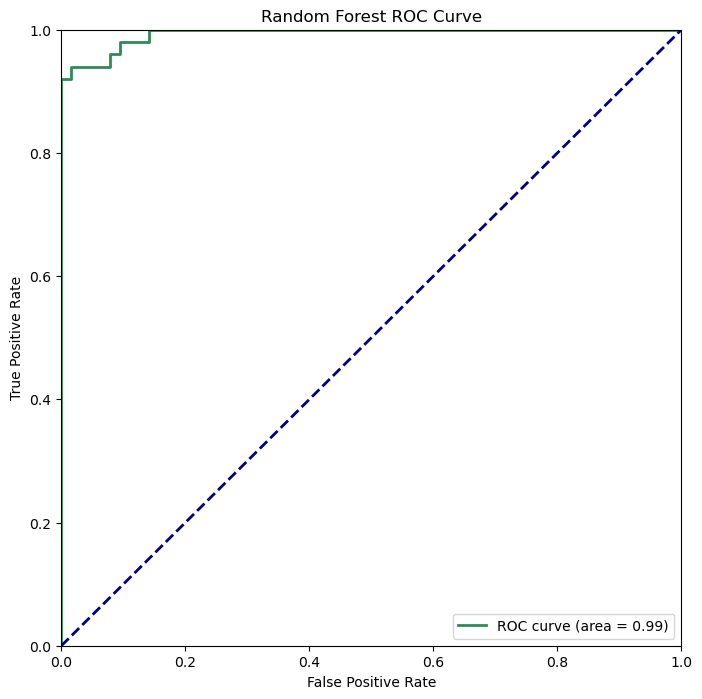

In [15]:
# Plot ROC Curve for Random Forest
plot_roc_curve(rf_predictions, "Random Forest ROC Curve")

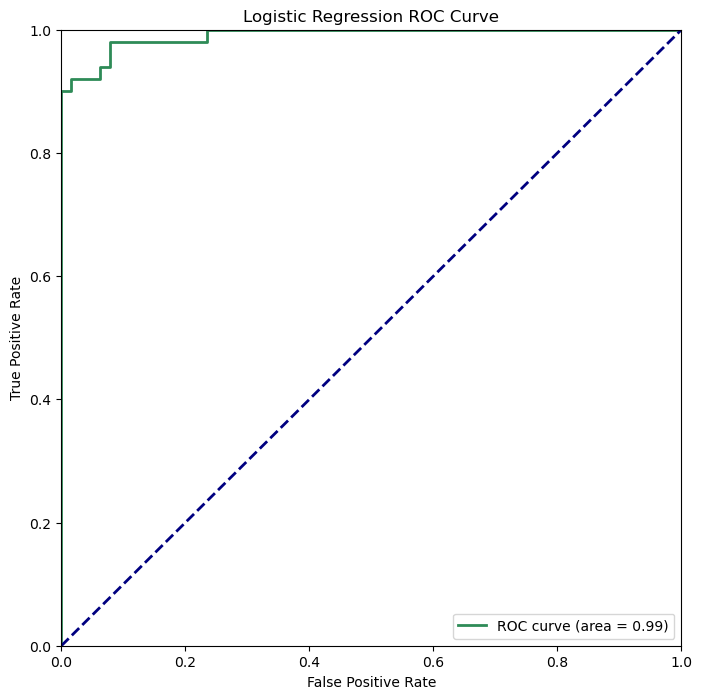

In [16]:
# Plot ROC Curve for Logistic Regression
plot_roc_curve(lr_predictions, "Logistic Regression ROC Curve")

In [17]:
# Stop SparkContext
sc.stop()